# Predict the Cost of Homes in California Using SageMaker Studio

In [2]:
import sagemaker
bucket=sagemaker.Session().default_bucket()
prefix = 'sagemaker/DEMO-xgboost-dm'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [3]:
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker 
import zipfile     # Amazon SageMaker's Python SDK provides many helper functions

# Get the data from SageMaker Feature Store

In [4]:
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup

region = boto3.Session().region_name
boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

feature_group_name = "FG-ndcDay-eeb28445" # replace with your feature group name 
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=feature_store_session)

In [5]:
# Build SQL query to features group
fs_query = feature_group.athena_query()
fs_table = fs_query.table_name
query_string = 'SELECT * FROM "'+fs_table+'"'
print('Running ' + query_string)

Running SELECT * FROM "fg-ndcday-eeb28445-1673227521"


In [6]:
# Run Athena query. The output is loaded to a Pandas dataframe.
fs_query.run(query_string=query_string, output_location='s3://'+bucket+'/'+prefix+'/fs_query_results/')
fs_query.wait()
model_data = fs_query.as_dataframe()

In [7]:
model_data

,housing_median_age,median_income,median_house_value,ocean_proximity__1h_ocean,ocean_proximity_inland,ocean_proximity_near_ocean,ocean_proximity_near_bay,ocean_proximity_island,rooms_per_household,bedrooms_per_room,population_per_household,coords,write_time,api_invocation_time,is_deleted
0,20.0,5.2595,110900.0,0.0,1.0,0.0,0.0,0.0,6.941685,0.138768,2.937365,-3.251697,2023-01-09 01:31:39.525,2023-01-09 01:31:39.525,False
1,16.0,5.0635,108500.0,0.0,1.0,0.0,0.0,0.0,6.573816,0.150424,2.880223,-3.251969,2023-01-09 01:31:39.525,2023-01-09 01:31:39.525,False
2,15.0,4.9292,109400.0,0.0,1.0,0.0,0.0,0.0,6.333333,0.156105,3.199546,-3.251425,2023-01-09 01:31:39.525,2023-01-09 01:31:39.525,False
3,14.0,4.1098,108200.0,0.0,1.0,0.0,0.0,0.0,5.940280,0.177326,2.839898,-3.251154,2023-01-09 01:31:39.525,2023-01-09 01:31:39.525,False
4,15.0,3.5078,109000.0,0.0,1.0,0.0,0.0,0.0,6.254587,0.183352,2.816514,-3.250339,2023-01-09 01:31:39.525,2023-01-09 01:31:39.525,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,27.0,3.8125,366700.0,1.0,0.0,0.0,0.0,0.0,5.044693,0.257475,2.209497,-3.508777,2023-01-09 01:31:39.525,2023-01-09 01:31:39.525,False
20636,26.0,8.1839,367000.0,1.0,0.0,0.0,0.0,0.0,7.900929,0.123041,2.863777,-3.502822,2023-01-09 01:31:39.525,2023-01-09 01:31:39.525,False
20637,34.0,7.1390,424000.0,1.0,0.0,0.0,0.0,0.0,7.094000,0.147449,2.374000,-3.468970,2023-01-09 01:31:39.525,2023-01-09 01:31:39.525,False
20638,46.0,6.0830,424000.0,1.0,0.0,0.0,0.0,0.0,6.310078,0.159091,1.937984,-3.467350,2023-01-09 01:31:39.525,2023-01-09 01:31:39.525,False


In [8]:
#remove unwanted columns
model_data = model_data.drop(['write_time', 'api_invocation_time', 'is_deleted'], axis=1)

In [9]:
model_data

,housing_median_age,median_income,median_house_value,ocean_proximity__1h_ocean,ocean_proximity_inland,ocean_proximity_near_ocean,ocean_proximity_near_bay,ocean_proximity_island,rooms_per_household,bedrooms_per_room,population_per_household,coords
0,20.0,5.2595,110900.0,0.0,1.0,0.0,0.0,0.0,6.941685,0.138768,2.937365,-3.251697
1,16.0,5.0635,108500.0,0.0,1.0,0.0,0.0,0.0,6.573816,0.150424,2.880223,-3.251969
2,15.0,4.9292,109400.0,0.0,1.0,0.0,0.0,0.0,6.333333,0.156105,3.199546,-3.251425
3,14.0,4.1098,108200.0,0.0,1.0,0.0,0.0,0.0,5.940280,0.177326,2.839898,-3.251154
4,15.0,3.5078,109000.0,0.0,1.0,0.0,0.0,0.0,6.254587,0.183352,2.816514,-3.250339
...,...,...,...,...,...,...,...,...,...,...,...,...
20635,27.0,3.8125,366700.0,1.0,0.0,0.0,0.0,0.0,5.044693,0.257475,2.209497,-3.508777
20636,26.0,8.1839,367000.0,1.0,0.0,0.0,0.0,0.0,7.900929,0.123041,2.863777,-3.502822
20637,34.0,7.1390,424000.0,1.0,0.0,0.0,0.0,0.0,7.094000,0.147449,2.374000,-3.468970
20638,46.0,6.0830,424000.0,1.0,0.0,0.0,0.0,0.0,6.310078,0.159091,1.937984,-3.467350


In [10]:
# Prepare data SageMaker's XGBoost
# Amazon SageMaker's XGBoost container expects data in CSV data format. 
# Note that the first column must be the target variable and the CSV should not include headers. 

# move target (ie, median_house_value) to first column
model_data2=model_data.reindex(columns= ['median_house_value', 'housing_median_age', 'median_income', 'ocean_proximity__1h_ocean',
                                         'ocean_proximity_inland','ocean_proximity_near_ocean', 'ocean_proximity_near_bay', 'ocean_proximity_island', 
                                         'rooms_per_household', 'bedrooms_per_room', 'population_per_household', 'coords'])
model_data2



,median_house_value,housing_median_age,median_income,ocean_proximity__1h_ocean,ocean_proximity_inland,ocean_proximity_near_ocean,ocean_proximity_near_bay,ocean_proximity_island,rooms_per_household,bedrooms_per_room,population_per_household,coords
0,110900.0,20.0,5.2595,0.0,1.0,0.0,0.0,0.0,6.941685,0.138768,2.937365,-3.251697
1,108500.0,16.0,5.0635,0.0,1.0,0.0,0.0,0.0,6.573816,0.150424,2.880223,-3.251969
2,109400.0,15.0,4.9292,0.0,1.0,0.0,0.0,0.0,6.333333,0.156105,3.199546,-3.251425
3,108200.0,14.0,4.1098,0.0,1.0,0.0,0.0,0.0,5.940280,0.177326,2.839898,-3.251154
4,109000.0,15.0,3.5078,0.0,1.0,0.0,0.0,0.0,6.254587,0.183352,2.816514,-3.250339
...,...,...,...,...,...,...,...,...,...,...,...,...
20635,366700.0,27.0,3.8125,1.0,0.0,0.0,0.0,0.0,5.044693,0.257475,2.209497,-3.508777
20636,367000.0,26.0,8.1839,1.0,0.0,0.0,0.0,0.0,7.900929,0.123041,2.863777,-3.502822
20637,424000.0,34.0,7.1390,1.0,0.0,0.0,0.0,0.0,7.094000,0.147449,2.374000,-3.468970
20638,424000.0,46.0,6.0830,1.0,0.0,0.0,0.0,0.0,6.310078,0.159091,1.937984,-3.467350


In [11]:
# remove the headers
model_data2.columns = range(model_data2.shape[1])   # Delete headers

model_data2

,0,1,2,3,4,5,6,7,8,9,10,11
0,110900.0,20.0,5.2595,0.0,1.0,0.0,0.0,0.0,6.941685,0.138768,2.937365,-3.251697
1,108500.0,16.0,5.0635,0.0,1.0,0.0,0.0,0.0,6.573816,0.150424,2.880223,-3.251969
2,109400.0,15.0,4.9292,0.0,1.0,0.0,0.0,0.0,6.333333,0.156105,3.199546,-3.251425
3,108200.0,14.0,4.1098,0.0,1.0,0.0,0.0,0.0,5.940280,0.177326,2.839898,-3.251154
4,109000.0,15.0,3.5078,0.0,1.0,0.0,0.0,0.0,6.254587,0.183352,2.816514,-3.250339
...,...,...,...,...,...,...,...,...,...,...,...,...
20635,366700.0,27.0,3.8125,1.0,0.0,0.0,0.0,0.0,5.044693,0.257475,2.209497,-3.508777
20636,367000.0,26.0,8.1839,1.0,0.0,0.0,0.0,0.0,7.900929,0.123041,2.863777,-3.502822
20637,424000.0,34.0,7.1390,1.0,0.0,0.0,0.0,0.0,7.094000,0.147449,2.374000,-3.468970
20638,424000.0,46.0,6.0830,1.0,0.0,0.0,0.0,0.0,6.310078,0.159091,1.937984,-3.467350


In [12]:
# separate data into train/test data split

#The model will be trained on 70% of data, it will then be evaluated on 20% of data to give us an estimate of the accuracy 
#we hope to have on "new" data, and 10% will be held back as a final testing dataset which will be used later on.

# Randomly sort the data then split out first 70%, second 20%, and last 10%
train_data, validation_data, test_data = np.split(model_data2.sample(frac=1, random_state=1729), 
                                                  [int(0.7 * len(model_data2)), int(0.9 * len(model_data2))]) 

In [13]:
# train data to CSV
train_data.to_csv('train.csv', index=False, header=False)
validation_data.to_csv('validation.csv', index=False, header=False)

In [14]:
#copy data to S3 for SageMaker to access
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

# Training

In [15]:
#specify the ECR container location for Amazon SageMaker's implementation of XGBoost

container = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='latest')

In [16]:
#Then, because we're training with the CSV file format, we'll create s3_inputs that our training function can use 
# as a pointer to the files in S3, which also specify that the content type is CSV.
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

First we'll need to specify training parameters to the estimator. This includes:

The xgboost algorithm container
The IAM role to use
Training instance type and count
S3 location for output data
Algorithm hyperparameters
And then a .fit() function which specifies:

S3 location for output data. In this case we have both a training and validation set which are passed in.

In [20]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5, #The maximum depth per tree. A deeper tree might increase the performance, 
                                     #but also the complexity and chances to overfit.
                        eta=0.2, #learning rate
                        gamma=4, #Gamma is a pseudo-regularisation parameter (Lagrangian multiplier), and depends on the other parameters. 
                                 #The higher Gamma is, the higher the regularization.
                        min_child_weight=6,
                        subsample=0.8, #Represents the fraction of observations to be sampled for each tree. 
                                       #A lower values prevent overfitting but might lead to under-fitting.
                        silent=0,
                        objective='reg:linear', #RMSE is the default metric for linear regression; 
                                                #The SageMaker XGBoost algorithm actually calculates RMSE and writes it to the 
                                                #CloudWatch logs on the data passed to the “validation” channel.
                        num_round=100 #number of trees
                       )

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

INFO:sagemaker:Creating training-job with name: xgboost-2023-05-21-11-37-25-682


2023-05-21 11:37:26 Starting - Starting the training job...
2023-05-21 11:37:50 Starting - Preparing the instances for training......
2023-05-21 11:39:06 Downloading - Downloading input data...
2023-05-21 11:39:36 Training - Downloading the training image......
2023-05-21 11:40:21 Training - Training image download completed. Training in progress..Arguments: train
[2023-05-21:11:40:33:INFO] Running standalone xgboost training.
[2023-05-21:11:40:33:INFO] File size need to be processed in the node: 2.02mb. Available memory size in the node: 8593.63mb
[2023-05-21:11:40:33:INFO] Determined delimiter of CSV input is ','
[11:40:33] S3DistributionType set as FullyReplicated
[11:40:33] 14447x11 matrix with 158917 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-05-21:11:40:33:INFO] Determined delimiter of CSV input is ','
[11:40:33] S3DistributionType set as FullyReplicated
[11:40:33] 4129x11 matrix with 45419 entries loaded from /opt/ml/input/data/valid

# Model Hosting w/ Endpoint Creation & Model Evaluation
Now that we have successfully trained our model, let’s deploy it and see how it does on the test data!

In [21]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2023-05-21-11-41-19-475
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-05-21-11-41-19-475
INFO:sagemaker:Creating endpoint with name xgboost-2023-05-21-11-41-19-475


------!

In [22]:
#need to make sure data is in correct format for deployed model
from sagemaker.predictor import csv_serializer, json_deserializer

xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()
xgb_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

In [23]:
test_data

,0,1,2,3,4,5,6,7,8,9,10,11
1459,54400.0,22.0,1.4792,0.0,1.0,0.0,0.0,0.0,4.153117,0.236868,2.933604,-3.295775
13935,176700.0,39.0,2.2167,1.0,0.0,0.0,0.0,0.0,3.447447,0.303136,3.486486,-3.466432
6843,140500.0,7.0,4.9196,0.0,1.0,0.0,0.0,0.0,6.315855,0.154181,4.061174,-3.440504
17103,355300.0,38.0,2.9643,1.0,0.0,0.0,0.0,0.0,3.740035,0.269694,1.838821,-3.471986
2286,79700.0,41.0,1.8220,0.0,0.0,0.0,1.0,0.0,5.608225,0.225782,3.545455,-3.225092
...,...,...,...,...,...,...,...,...,...,...,...,...
13379,202400.0,23.0,4.7422,1.0,0.0,0.0,0.0,0.0,5.406844,0.182841,4.152091,-3.497182
11646,175000.0,13.0,1.9063,1.0,0.0,0.0,0.0,0.0,3.453125,0.285068,4.468750,-3.478363
1267,101000.0,17.0,3.5189,0.0,1.0,0.0,0.0,0.0,5.498201,0.188747,2.692446,-3.010111
3174,89400.0,16.0,2.3886,0.0,1.0,0.0,0.0,0.0,5.254717,0.221185,2.616981,-3.079502


In [24]:
# axis where 1 is the axis number (0 for rows and 1 for columns.)
# To delete the column without having to reassign df you can do - inplace = False

test_data_median_house_value_column = test_data.drop(columns=test_data.columns[[1,2,3,4,5,6,7,8,9,10,11]], axis=1, inplace=False)

test_data_median_house_value_column

,0
1459,54400.0
13935,176700.0
6843,140500.0
17103,355300.0
2286,79700.0
...,...
13379,202400.0
11646,175000.0
1267,101000.0
3174,89400.0


In [25]:
#drop first column of test data, the first column shouldn't be the target
test_data.drop(columns=test_data.columns[0], axis=1, inplace=True)

In [26]:
test_data

,1,2,3,4,5,6,7,8,9,10,11
1459,22.0,1.4792,0.0,1.0,0.0,0.0,0.0,4.153117,0.236868,2.933604,-3.295775
13935,39.0,2.2167,1.0,0.0,0.0,0.0,0.0,3.447447,0.303136,3.486486,-3.466432
6843,7.0,4.9196,0.0,1.0,0.0,0.0,0.0,6.315855,0.154181,4.061174,-3.440504
17103,38.0,2.9643,1.0,0.0,0.0,0.0,0.0,3.740035,0.269694,1.838821,-3.471986
2286,41.0,1.8220,0.0,0.0,0.0,1.0,0.0,5.608225,0.225782,3.545455,-3.225092
...,...,...,...,...,...,...,...,...,...,...,...
13379,23.0,4.7422,1.0,0.0,0.0,0.0,0.0,5.406844,0.182841,4.152091,-3.497182
11646,13.0,1.9063,1.0,0.0,0.0,0.0,0.0,3.453125,0.285068,4.468750,-3.478363
1267,17.0,3.5189,0.0,1.0,0.0,0.0,0.0,5.498201,0.188747,2.692446,-3.010111
3174,16.0,2.3886,0.0,1.0,0.0,0.0,0.0,5.254717,0.221185,2.616981,-3.079502


# Inference

In [27]:
# run the prediction on a single observation
prediction = xgb_predictor.predict(np.array([26.0, 2.5179, 0.0, 1.0, 0.0, 0.0, 0.0, 5.334174, 0.194563, 3.517024, -3.403054]))
prediction

84559.546875

In [28]:
#run predictions on the entire test data set

def predict(data, predictor, rows=500 ):
    #splits test dataset into 5 arrays of observations
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    
    for array in split_array:
        for observation in array:
            prediction = predictor.predict(observation)
            predictions = ','.join([predictions, str(prediction)])
            
    return np.fromstring(predictions[1:], sep=',')

#numpy array of predictions
predictions = predict(test_data.to_numpy(), xgb_predictor)
print(predictions)

[ 66860.5234375 161418.328125  148066.609375  ... 107988.390625
  97146.9296875 121328.3671875]


In [29]:
print(predictions[0])

66860.5234375


In [30]:
print(predictions[1])

161418.328125


In [31]:
print(predictions[2])

148066.609375


In [32]:
# convert DF to 1-dimensional array for easy comparison
test_data_median_house_value_column_array = test_data_median_house_value_column.values.flatten()

# Default value of display.max_rows is 10 so at max
# 10 rows will be printed. Set it None to display
# all rows in the dataframe
pd.set_option('display.max_rows', None)

comparison_df = pd.DataFrame({'Actual': test_data_median_house_value_column_array, 'Predicted': predictions})

# Turn on output cell scrolling
# Cell>Enable Scrolling for outputs
comparison_df

,Actual,Predicted
0,54400.0,66860.523438
1,176700.0,161418.328125
2,140500.0,148066.609375
3,355300.0,337109.031250
4,79700.0,101949.125000
5,335700.0,296105.343750
6,183300.0,163420.140625
7,500001.0,523845.281250
8,234300.0,386103.437500
9,252200.0,374013.656250


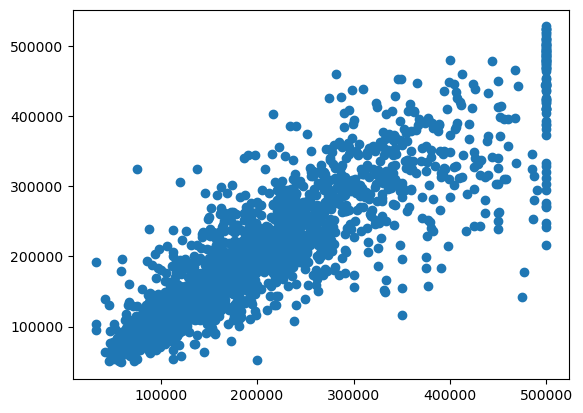

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.scatter(test_data_median_house_value_column, predictions, c=test_data_median_house_value_column, cmap='gray')
plt.scatter(test_data_median_house_value_column_array, predictions)

# Calculate R^2 Metric

In [34]:
from sklearn import metrics 

#R^2
r2 = round(metrics.r2_score(test_data_median_house_value_column_array, predictions),2)
print("R^2: {}".format(r2))

R^2: 0.78


# Challenge 1

## Automatic Model Tuning (ie, hyperparameter tuning)
Automatic model tuning finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose. 

Tunable parameters for XGBoost: https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html; not every hyperparameter is tunable

In [35]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'eta': ContinuousParameter(0.1, 1),
                         'max_depth': IntegerParameter(10, 20),
                         'subsample': ContinuousParameter(0.5, 1),
                         'min_child_weight': IntegerParameter(5, 15),
                         'gamma': ContinuousParameter(0.1, 1)}

In [36]:
objective_metric_name = 'validation:rmse'
objective_type = 'Minimize'
metric_definitions = [{'Name': 'rmse', 'Regex': 'rmse: ([0-9\.]+)'}]

In [37]:
tuner = HyperparameterTuner(xgb,
                            hyperparameter_ranges=hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3,
                            objective_type=objective_type,
                            objective_metric_name=objective_metric_name,
                            metric_definitions=metric_definitions)

In [38]:
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating hyperparameter tuning job with name: xgboost-230521-1145


.....................................................................................................!


In [39]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

In [40]:
# return the best training job name
tuner.best_training_job()

'xgboost-230521-1145-016-144d08b6'

In [41]:
# Deploy the best trained or user specified model to an Amazon SageMaker endpoint
tuner_predictor = tuner.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')


2023-05-21 11:52:59 Starting - Found matching resource for reuse
2023-05-21 11:52:59 Downloading - Downloading input data
2023-05-21 11:52:59 Training - Training image download completed. Training in progress.
2023-05-21 11:52:59 Uploading - Uploading generated training model
2023-05-21 11:52:59 Completed - Resource reused by training job: xgboost-230521-1145-019-0a6fc77a

INFO:sagemaker:Creating model with name: xgboost-2023-05-21-11-54-00-537


INFO:sagemaker:Creating endpoint-config with name xgboost-230521-1145-016-144d08b6
INFO:sagemaker:Creating endpoint with name xgboost-230521-1145-016-144d08b6


-------!

In [42]:
tuner_predictor.serializer = sagemaker.serializers.CSVSerializer()
tuner_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

In [43]:
#numpy array of predictions
tuner_predictions = predict(test_data.to_numpy(), tuner_predictor)
print(tuner_predictions)

[ 60466.9375    180293.578125  162754.3125    ... 108377.6328125
  97474.3359375 119220.25     ]


In [44]:
tuner_comparison_df = pd.DataFrame({'Actual': test_data_median_house_value_column_array, 'Predicted': tuner_predictions})

# Turn on output cell scrolling
# Cell>Enable Scrolling for outputs
tuner_comparison_df

,Actual,Predicted
0,54400.0,60466.937500
1,176700.0,180293.578125
2,140500.0,162754.312500
3,355300.0,322794.500000
4,79700.0,90563.953125
5,335700.0,264167.031250
6,183300.0,155816.406250
7,500001.0,496768.843750
8,234300.0,402337.562500
9,252200.0,390464.656250


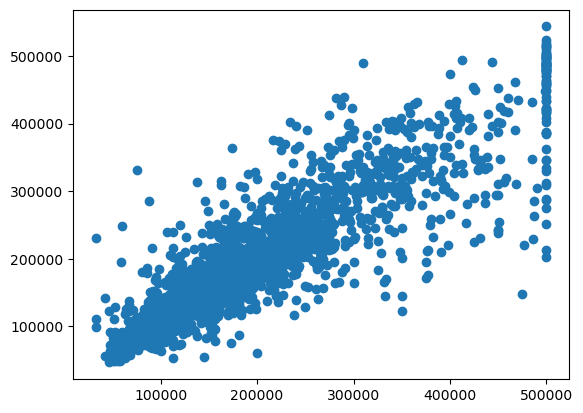

In [45]:
plt.scatter(test_data_median_house_value_column_array, tuner_predictions)

In [46]:
r2 = round(metrics.r2_score(test_data_median_house_value_column_array, tuner_predictions),2)
print("R^2: {}".format(r2))

R^2: 0.78


# Clean-up
If you’re ready to be done with this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [47]:
xgb_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: xgboost-2023-05-21-11-41-19-475
INFO:sagemaker:Deleting endpoint with name: xgboost-2023-05-21-11-41-19-475


In [48]:
tuner_predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: xgboost-230521-1145-016-144d08b6
INFO:sagemaker:Deleting endpoint with name: xgboost-230521-1145-016-144d08b6
